# YouTube Trending Videos Analysis

This notebook analyzes YouTube trending video data to identify patterns and insights about content performance, publishing strategies, and audience preferences.

## Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
from datetime import datetime
import re
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set styling
plt.style.use('fivethirtyeight')
sns.set_palette('viridis')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

## Load and Prepare the Data

In [2]:
# Load the data
df = pd.read_csv('Data.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
df.info()

Dataset shape: (2155, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Type              2155 non-null   object
 1   Channel Name      2155 non-null   object
 2   Title             2155 non-null   object
 3   Channel ID        2155 non-null   object
 4   Views             2155 non-null   int64 
 5   Publication Date  2140 non-null   object
 6   Duration          2155 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 118.0+ KB


In [3]:
# Preview the data
df.head()

,Type,Channel Name,Title,Channel ID,Views,Publication Date,Duration
0,video,Brian Weissman,Unlock Consistent Power in Disc Golf: Discover...,Unknown,5763,2025-02-12,436
1,video,Brian Weissman,Fix Your Pesky Back Foot Disc Golf Throw,Unknown,36925,2025-02-12,923
2,video,Brian Weissman,X-Step Mastery Disc Golf Form Evolution,Unknown,695,2025-02-24,330
3,video,Brian Weissman,INSANE Disc Golf Drills To Level Up Your Game,Unknown,597,2025-02-23,733
4,video,Brian Weissman,What's your favorite disc for long bombs?,Unknown,900,2025-02-22,960


In [4]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

print("Missing values in each column:")
missing_df

Missing values in each column:


,Missing Values,Percentage
Type,0,0.000000
Channel Name,0,0.000000
Title,0,0.000000
Channel ID,0,0.000000
Views,0,0.000000
Publication Date,15,0.696056
Duration,0,0.000000


In [5]:
# Convert Publication Date to datetime
df['Publication Date'] = pd.to_datetime(df['Publication Date'])

# Create additional date features
df['Day of Week'] = df['Publication Date'].dt.day_name()
df['Month'] = df['Publication Date'].dt.month_name()
df['Year'] = df['Publication Date'].dt.year

# Convert Duration to minutes for better readability
df['Duration (min)'] = df['Duration'] / 60

# Create a duration category column
def duration_category(seconds):
    if seconds < 60:
        return '< 1 min'
    elif seconds < 180:
        return '1-3 mins'
    elif seconds < 300:
        return '3-5 mins'
    elif seconds < 600:
        return '5-10 mins'
    elif seconds < 900:
        return '10-15 mins'
    else:
        return '15+ mins'

df['Duration Category'] = df['Duration'].apply(duration_category)

# Create a view count category column
def view_category(views):
    if views < 10000:
        return '< 10K'
    elif views < 100000:
        return '10K-100K'
    elif views < 500000:
        return '100K-500K'
    elif views < 1000000:
        return '500K-1M'
    elif views < 5000000:
        return '1M-5M'
    elif views < 10000000:
        return '5M-10M'
    else:
        return '10M+'

df['View Category'] = df['Views'].apply(view_category)

## Basic Statistics

In [6]:
# Calculate basic view statistics
view_stats = {
    'Total Views': df['Views'].sum(),
    'Average Views': df['Views'].mean(),
    'Median Views': df['Views'].median(),
    'Min Views': df['Views'].min(),
    'Max Views': df['Views'].max()
}

for stat, value in view_stats.items():
    if stat == 'Total Views':
        print(f"{stat}: {value:,.0f}")
    else:
        print(f"{stat}: {value:,.0f}")

Total Views: 7,665,214,145
Average Views: 3,556,944
Median Views: 642,332
Min Views: 597
Max Views: 96,112,959


In [7]:
# Calculate basic duration statistics
duration_stats = {
    'Average Duration (seconds)': df['Duration'].mean(),
    'Median Duration (seconds)': df['Duration'].median(),
    'Min Duration (seconds)': df['Duration'].min(),
    'Max Duration (seconds)': df['Duration'].max(),
    'Average Duration (minutes)': df['Duration (min)'].mean(),
    'Median Duration (minutes)': df['Duration (min)'].median()
}

for stat, value in duration_stats.items():
    print(f"{stat}: {value:.2f}")

Average Duration (seconds): 760.41
Median Duration (seconds): 603.00
Min Duration (seconds): 50.00
Max Duration (seconds): 42896.00
Average Duration (minutes): 12.67
Median Duration (minutes): 10.05


## Channel Analysis

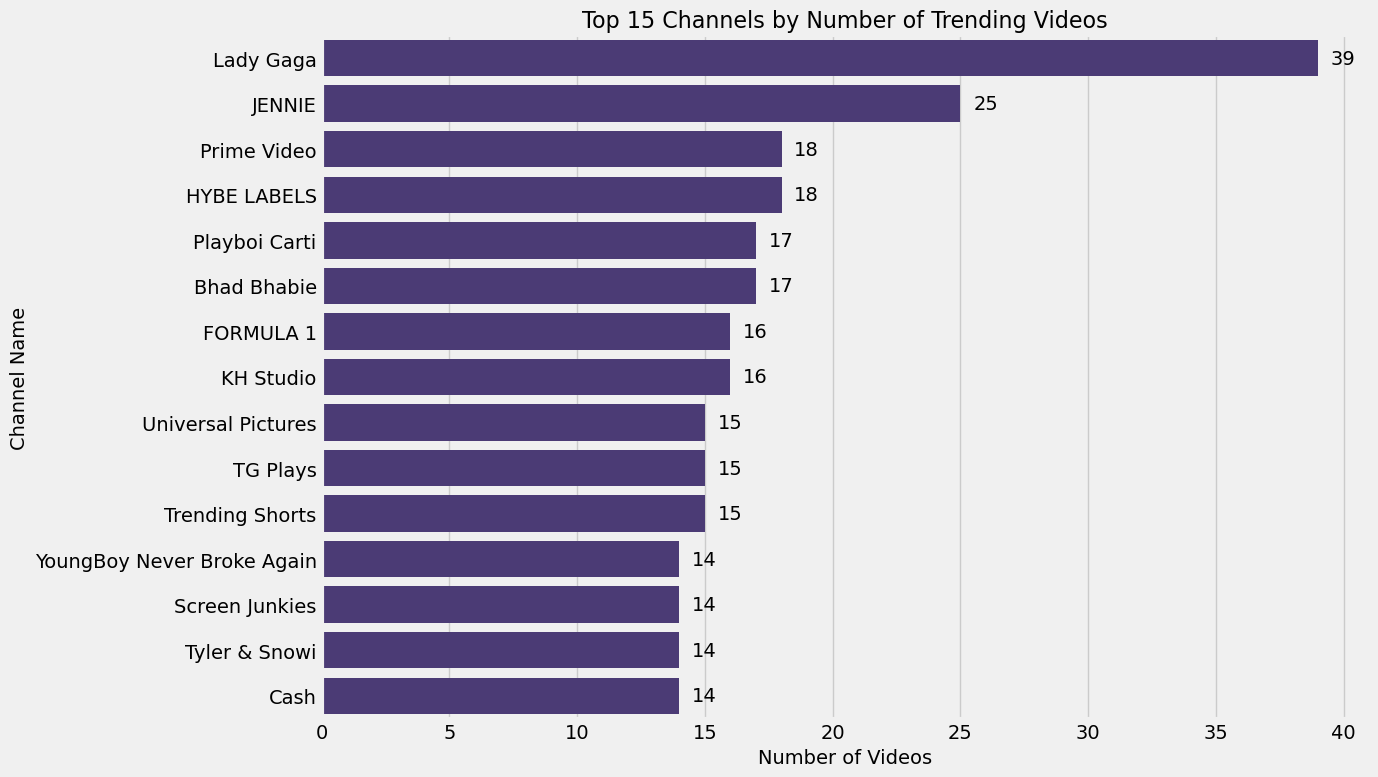

In [8]:
# Top 15 most frequent channels
top_channels = df['Channel Name'].value_counts().head(15)
plt.figure(figsize=(14, 8))
ax = sns.barplot(x=top_channels.values, y=top_channels.index)
plt.title('Top 15 Channels by Number of Trending Videos', fontsize=16)
plt.xlabel('Number of Videos', fontsize=14)
plt.ylabel('Channel Name', fontsize=14)

# Add count labels to the bars
for i, v in enumerate(top_channels.values):
    ax.text(v + 0.5, i, str(v), va='center')

plt.tight_layout()
plt.show()

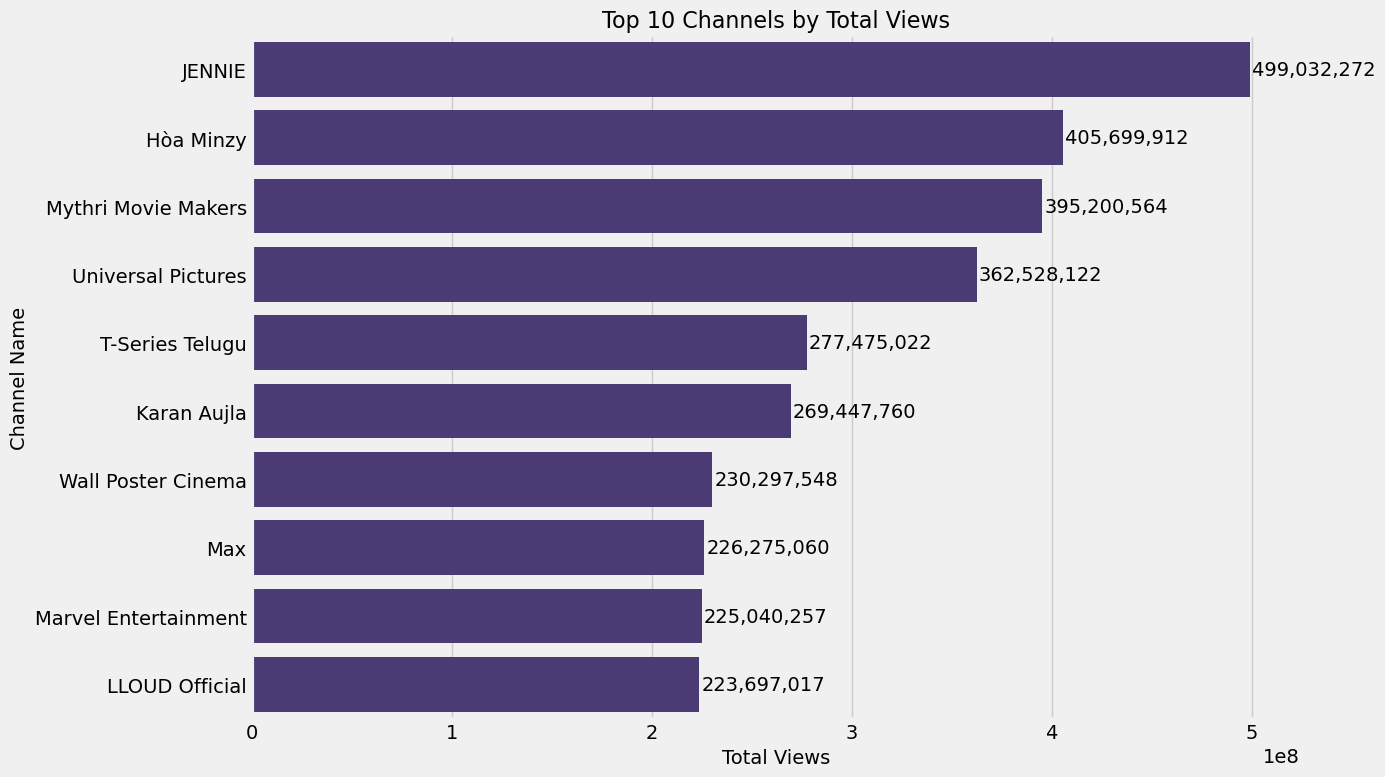

In [9]:
# Top 10 channels by total views
channel_views = df.groupby('Channel Name')['Views'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(14, 8))
ax = sns.barplot(x=channel_views.values, y=channel_views.index)
plt.title('Top 10 Channels by Total Views', fontsize=16)
plt.xlabel('Total Views', fontsize=14)
plt.ylabel('Channel Name', fontsize=14)

# Add formatted view count labels
for i, v in enumerate(channel_views.values):
    ax.text(v + 1e6, i, f"{v:,.0f}", va='center')

plt.tight_layout()
plt.show()

## Content Analysis

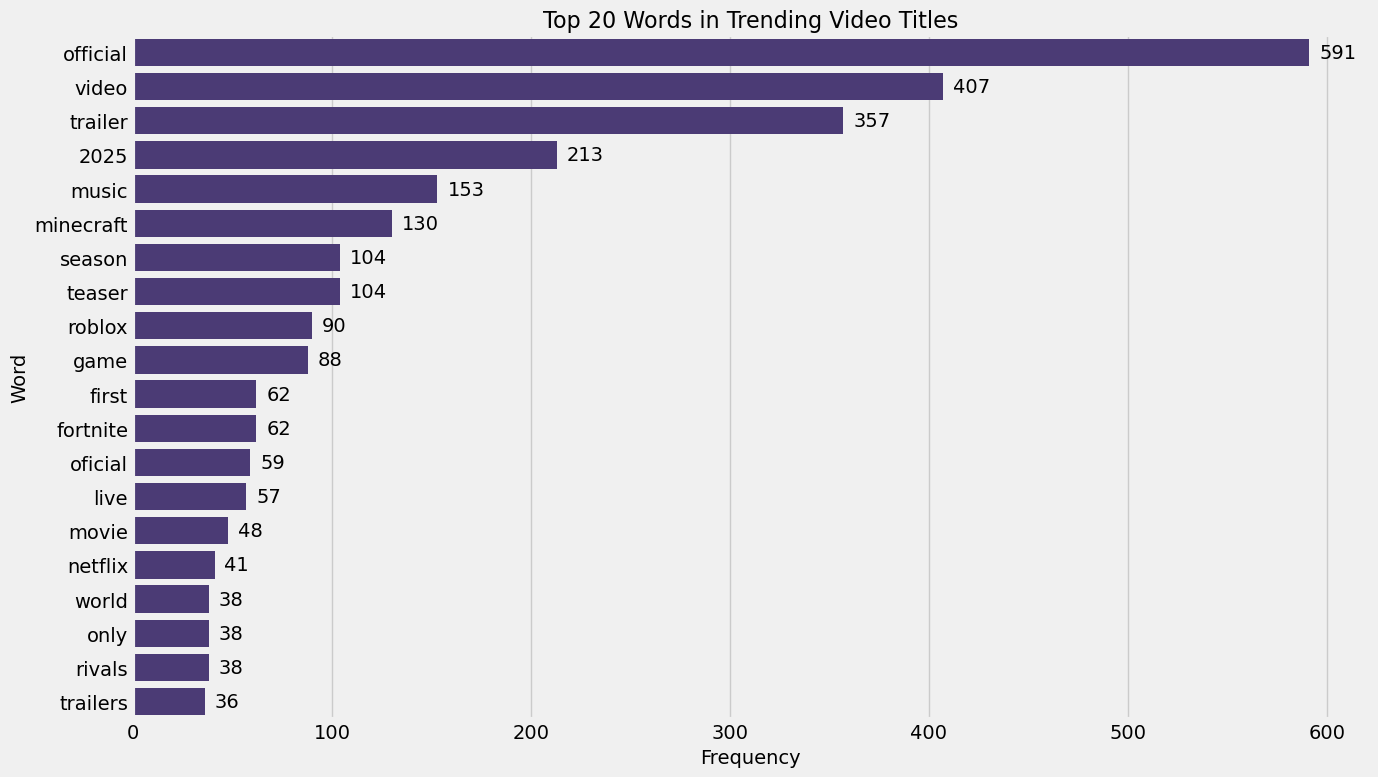

In [10]:
# Analyze the most common words in video titles
def extract_words(title):
    if isinstance(title, str):
        # Convert to lowercase, remove punctuation, and split by whitespace
        words = re.findall(r'\w+', title.lower())
        # Filter out short words (typically less informative)
        return [word for word in words if len(word) > 3]
    return []

# Create a list of all words in titles
all_words = []
for title in df['Title']:
    all_words.extend(extract_words(title))

# Count word frequencies
word_counts = Counter(all_words)

# Common English stop words to exclude
stop_words = {'that', 'this', 'with', 'from', 'have', 'what', 'will', 'your', 'when', 'they', 'just', 'like'}

# Filter out stop words
filtered_word_counts = {word: count for word, count in word_counts.items() if word not in stop_words}

# Get the top 20 words
top_words = pd.Series(filtered_word_counts).sort_values(ascending=False).head(20)

plt.figure(figsize=(14, 8))
ax = sns.barplot(x=top_words.values, y=top_words.index)
plt.title('Top 20 Words in Trending Video Titles', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Word', fontsize=14)

# Add count labels
for i, v in enumerate(top_words.values):
    ax.text(v + 5, i, str(v), va='center')

plt.tight_layout()
plt.show()

In [11]:
# Create a word cloud of title words
plt.figure(figsize=(14, 10))
wordcloud = WordCloud(width=800, height=400, background_color='white', 
                      max_words=100, colormap='viridis',
                      contour_width=1, contour_color='steelblue').generate_from_frequencies(filtered_word_counts)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Trending Video Titles', fontsize=20)
plt.tight_layout()
plt.show()

NameError: name 'WordCloud' is not defined

/var/folders/6_/4pssx0rj0ln4w7ysqm50xw400000gn/T/ipykernel_99475/773026839.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


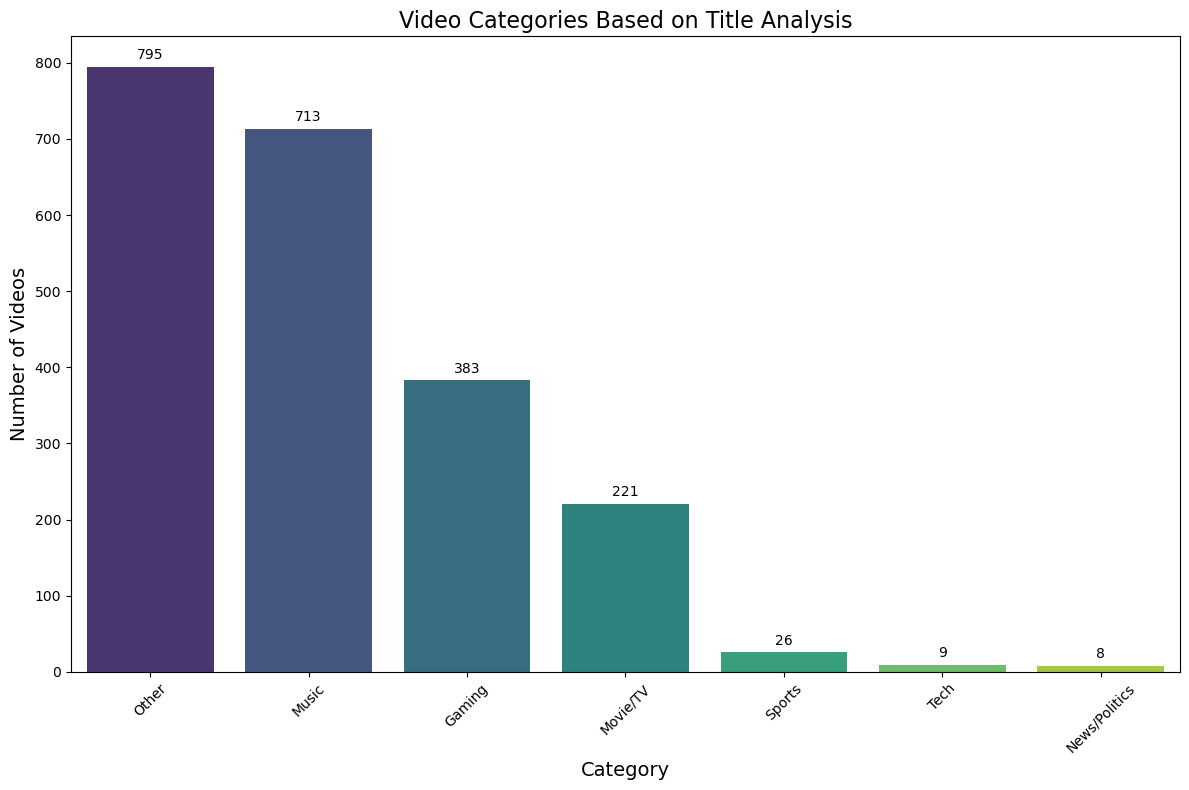

In [ ]:
# Categorize videos based on title keywords
def categorize_video(title):
    if not isinstance(title, str):
        return 'Unknown'
    
    title = title.lower()
    
    if any(word in title for word in ['music', 'song', 'official', 'audio', 'video', 'lyric', 'remix', 'ft.', 'feat']):
        return 'Music'
    elif any(word in title for word in ['game', 'gaming', 'minecraft', 'fortnite', 'roblox', 'gameplay']):
        return 'Gaming'
    elif any(word in title for word in ['trailer', 'movie', 'film', 'series', 'netflix', 'show', 'season', 'episode']):
        return 'Movie/TV'
    elif any(word in title for word in ['football', 'basketball', 'nba', 'nfl', 'sport', 'match', 'highlights']):
        return 'Sports'
    elif any(word in title for word in ['tech', 'iphone', 'samsung', 'review', 'unboxing', 'apple']):
        return 'Tech'
    elif any(word in title for word in ['news', 'politics', 'president', 'election', 'debate']):
        return 'News/Politics'
    else:
        return 'Other'

df['Category'] = df['Title'].apply(categorize_video)

# Plot category distribution
category_counts = df['Category'].value_counts()
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.title('Video Categories Based on Title Analysis', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Number of Videos', fontsize=14)
plt.xticks(rotation=45)

# Add count labels
for i, v in enumerate(category_counts.values):
    ax.text(i, v + 10, str(v), ha='center')

plt.tight_layout()
plt.show()

## Time-Based Analysis

/var/folders/6_/4pssx0rj0ln4w7ysqm50xw400000gn/T/ipykernel_99475/1943960900.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=day_counts.index, y=day_counts.values, palette='viridis')


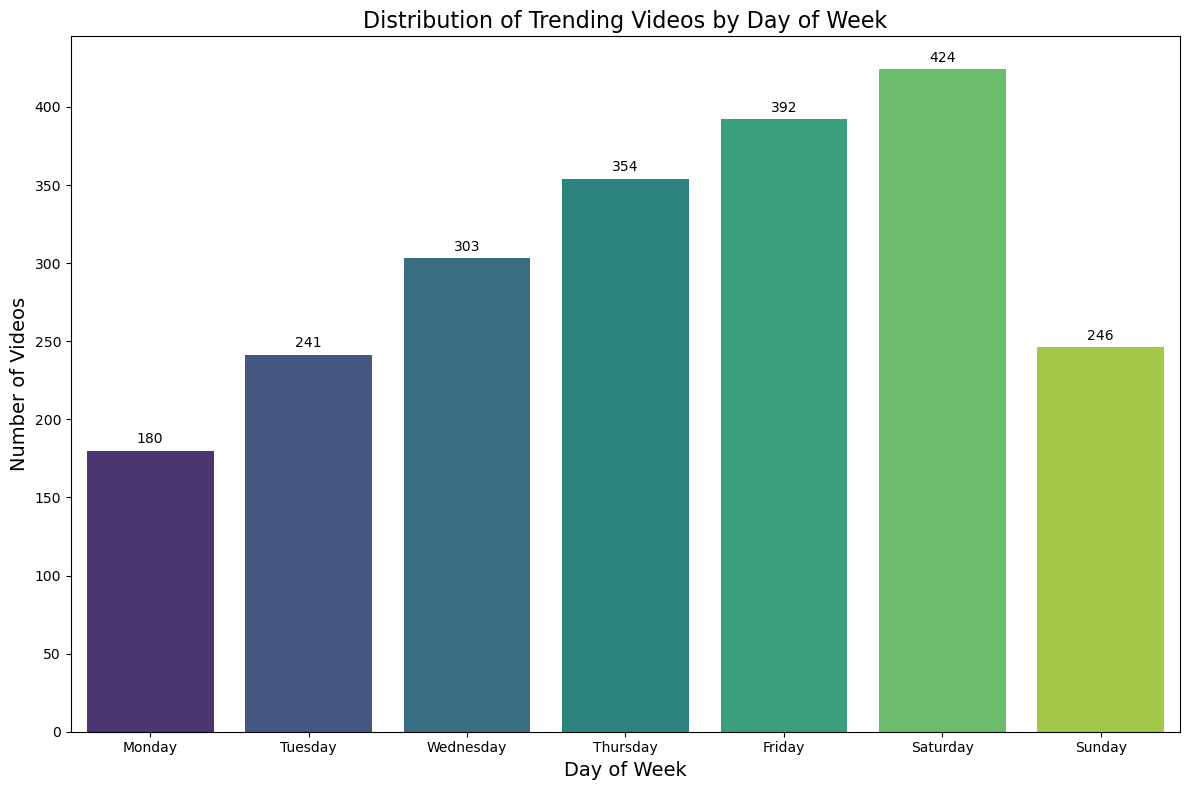

In [ ]:
# Day of week distribution
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = df['Day of Week'].value_counts().reindex(day_order)

plt.figure(figsize=(12, 8))
ax = sns.barplot(x=day_counts.index, y=day_counts.values, palette='viridis')
plt.title('Distribution of Trending Videos by Day of Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Number of Videos', fontsize=14)

# Add count labels
for i, v in enumerate(day_counts.values):
    ax.text(i, v + 5, str(v), ha='center')

plt.tight_layout()
plt.show()

/var/folders/6_/4pssx0rj0ln4w7ysqm50xw400000gn/T/ipykernel_99475/2073619933.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=month_counts.index, y=month_counts.values, palette='viridis')


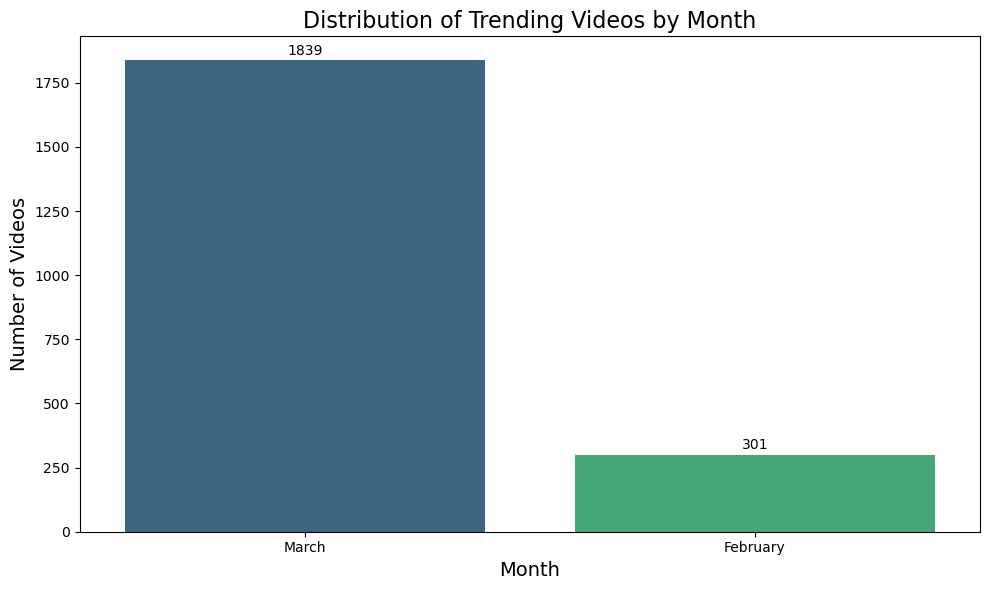

In [ ]:
# Month distribution
month_counts = df['Month'].value_counts()
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=month_counts.index, y=month_counts.values, palette='viridis')
plt.title('Distribution of Trending Videos by Month', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Videos', fontsize=14)

# Add count labels
for i, v in enumerate(month_counts.values):
    ax.text(i, v + 20, str(v), ha='center')

plt.tight_layout()
plt.show()

/var/folders/6_/4pssx0rj0ln4w7ysqm50xw400000gn/T/ipykernel_99475/307866240.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=day_avg_views.index, y=day_avg_views.values, palette='viridis')


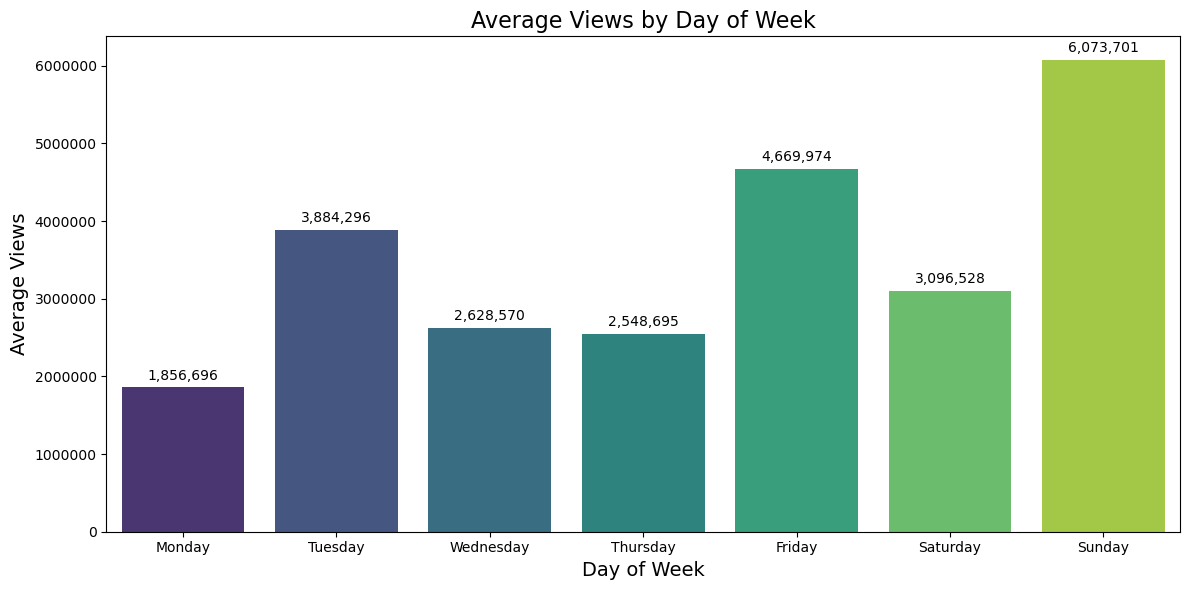

In [ ]:
# Analyze day of week by average views
day_avg_views = df.groupby('Day of Week')['Views'].mean().reindex(day_order)
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=day_avg_views.index, y=day_avg_views.values, palette='viridis')
plt.title('Average Views by Day of Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Average Views', fontsize=14)
plt.ticklabel_format(style='plain', axis='y')

# Add formatted view count labels
for i, v in enumerate(day_avg_views.values):
    ax.text(i, v + 100000, f"{v:,.0f}", ha='center')

plt.tight_layout()
plt.show()

## Duration Analysis

/var/folders/6_/4pssx0rj0ln4w7ysqm50xw400000gn/T/ipykernel_99475/1943317026.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=duration_counts.index, y=duration_counts.values, palette='viridis')


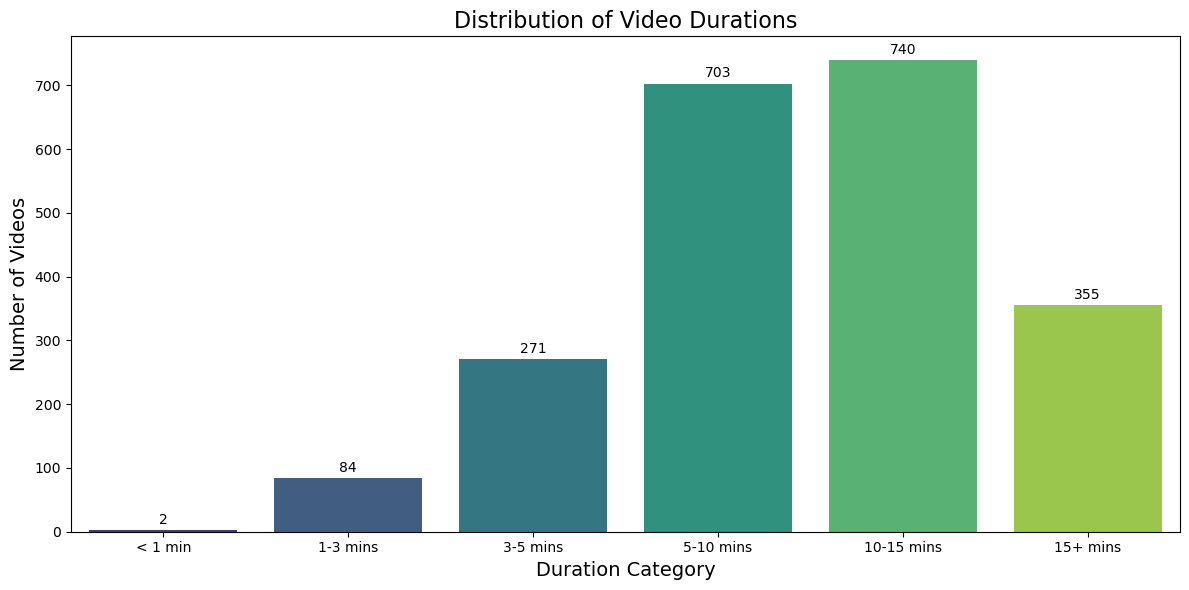

In [ ]:
# Distribution of video duration categories
duration_order = ['< 1 min', '1-3 mins', '3-5 mins', '5-10 mins', '10-15 mins', '15+ mins']
duration_counts = df['Duration Category'].value_counts().reindex(duration_order)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=duration_counts.index, y=duration_counts.values, palette='viridis')
plt.title('Distribution of Video Durations', fontsize=16)
plt.xlabel('Duration Category', fontsize=14)
plt.ylabel('Number of Videos', fontsize=14)

# Add count labels
for i, v in enumerate(duration_counts.values):
    ax.text(i, v + 10, str(v), ha='center')

plt.tight_layout()
plt.show()

/var/folders/6_/4pssx0rj0ln4w7ysqm50xw400000gn/T/ipykernel_99475/2479065612.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=duration_avg_views.index, y=duration_avg_views.values, palette='viridis')


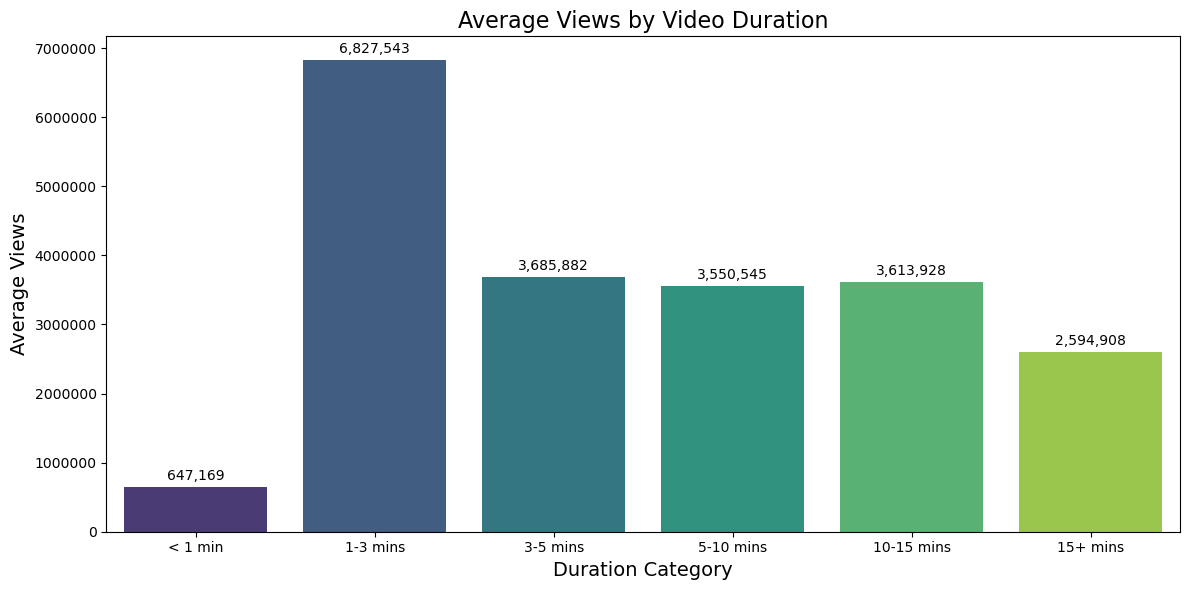

In [ ]:
# Average views by duration category
duration_avg_views = df.groupby('Duration Category')['Views'].mean().reindex(duration_order)
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=duration_avg_views.index, y=duration_avg_views.values, palette='viridis')
plt.title('Average Views by Video Duration', fontsize=16)
plt.xlabel('Duration Category', fontsize=14)
plt.ylabel('Average Views', fontsize=14)
plt.ticklabel_format(style='plain', axis='y')

# Add formatted view count labels
for i, v in enumerate(duration_avg_views.values):
    ax.text(i, v + 100000, f"{v:,.0f}", ha='center')

plt.tight_layout()
plt.show()

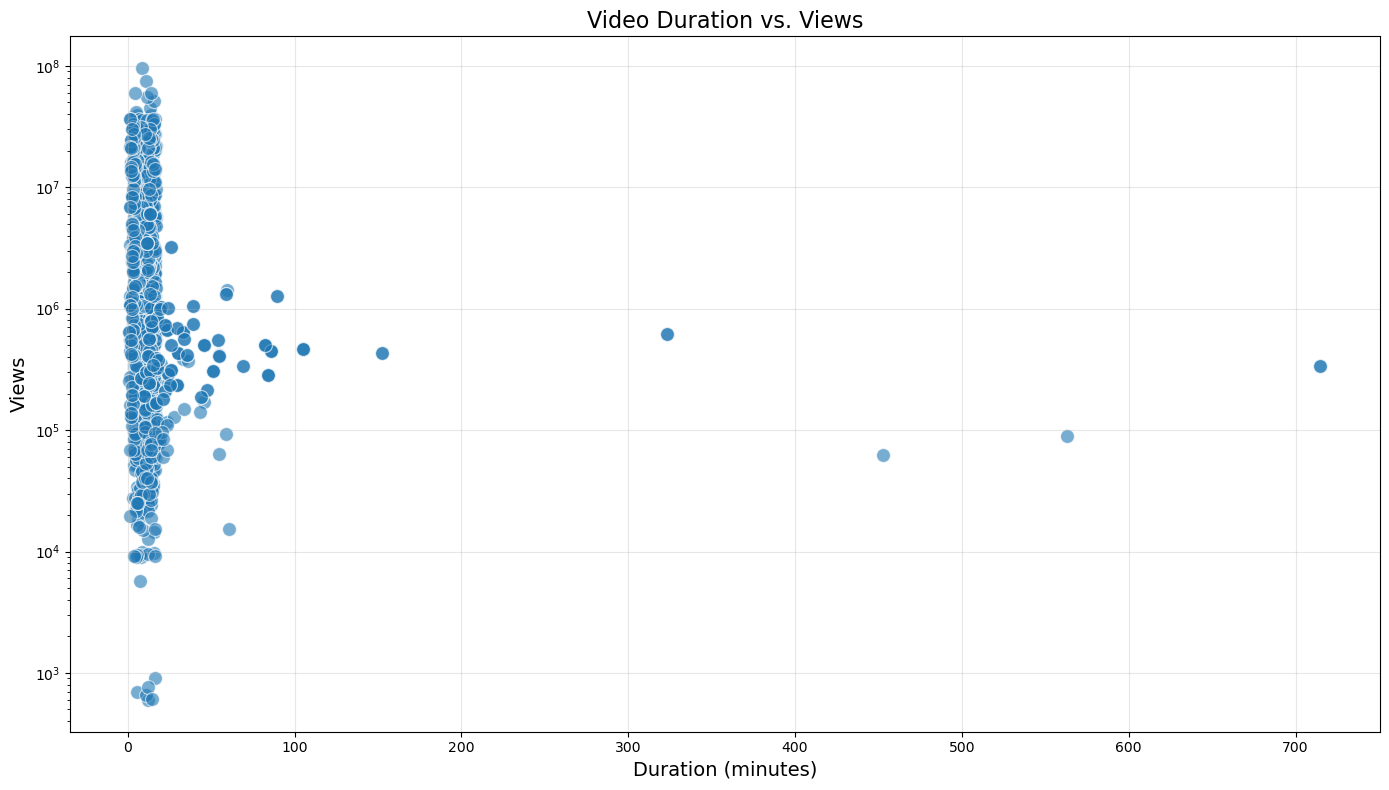

Correlation between video duration and views: -0.0475


In [ ]:
# Scatter plot of duration vs. views
plt.figure(figsize=(14, 8))
sns.scatterplot(x='Duration (min)', y='Views', data=df, alpha=0.6, s=100)
plt.title('Video Duration vs. Views', fontsize=16)
plt.xlabel('Duration (minutes)', fontsize=14)
plt.ylabel('Views', fontsize=14)
plt.yscale('log')  # Log scale for better visualization
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate correlation between duration and views
correlation = df['Duration'].corr(df['Views'])
print(f"Correlation between video duration and views: {correlation:.4f}")

## View Count Distribution

/var/folders/6_/4pssx0rj0ln4w7ysqm50xw400000gn/T/ipykernel_99475/2996286298.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=view_counts.index, y=view_counts.values, palette='viridis')


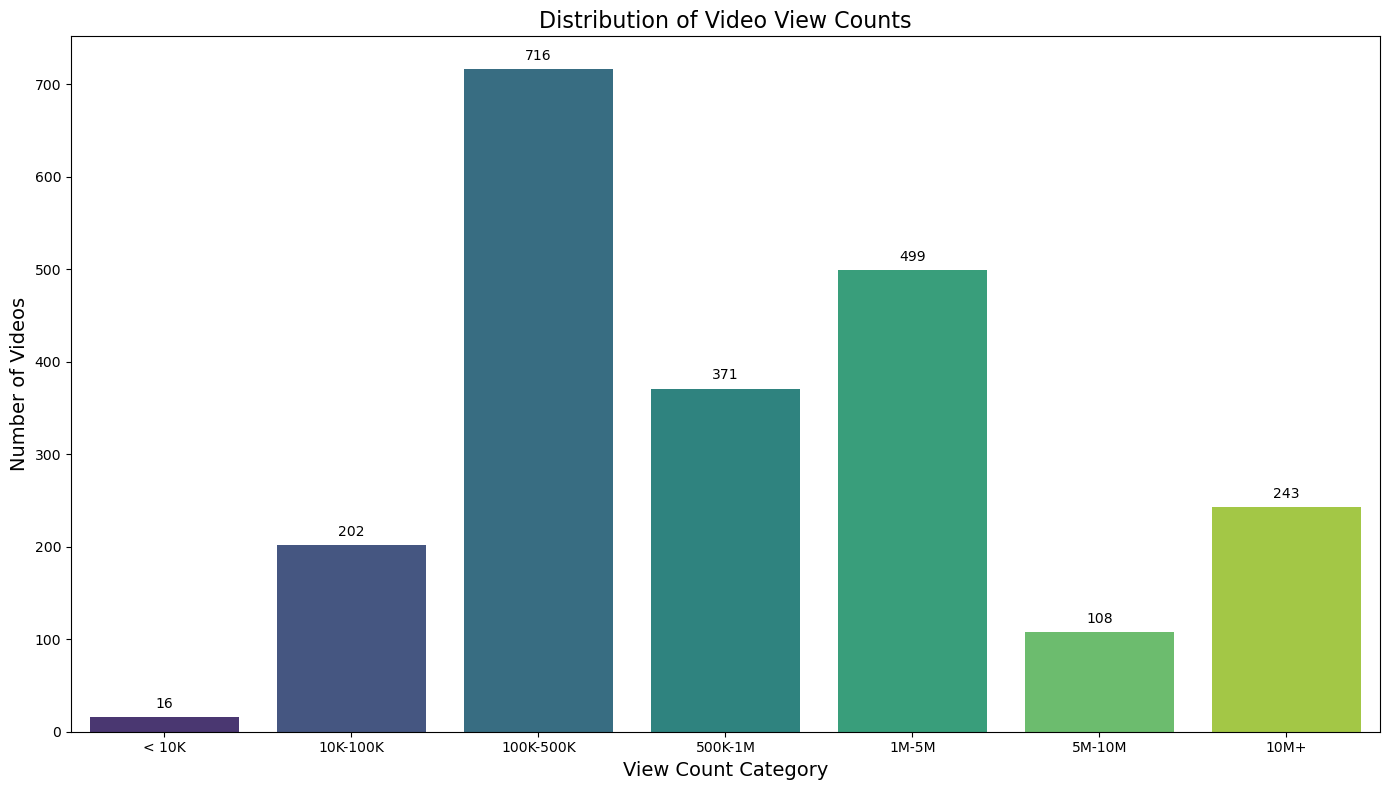

In [ ]:
# Distribution of view count categories
view_order = ['< 10K', '10K-100K', '100K-500K', '500K-1M', '1M-5M', '5M-10M', '10M+']
view_counts = df['View Category'].value_counts().reindex(view_order)

plt.figure(figsize=(14, 8))
ax = sns.barplot(x=view_counts.index, y=view_counts.values, palette='viridis')
plt.title('Distribution of Video View Counts', fontsize=16)
plt.xlabel('View Count Category', fontsize=14)
plt.ylabel('Number of Videos', fontsize=14)

# Add count labels
for i, v in enumerate(view_counts.values):
    ax.text(i, v + 10, str(v), ha='center')

plt.tight_layout()
plt.show()

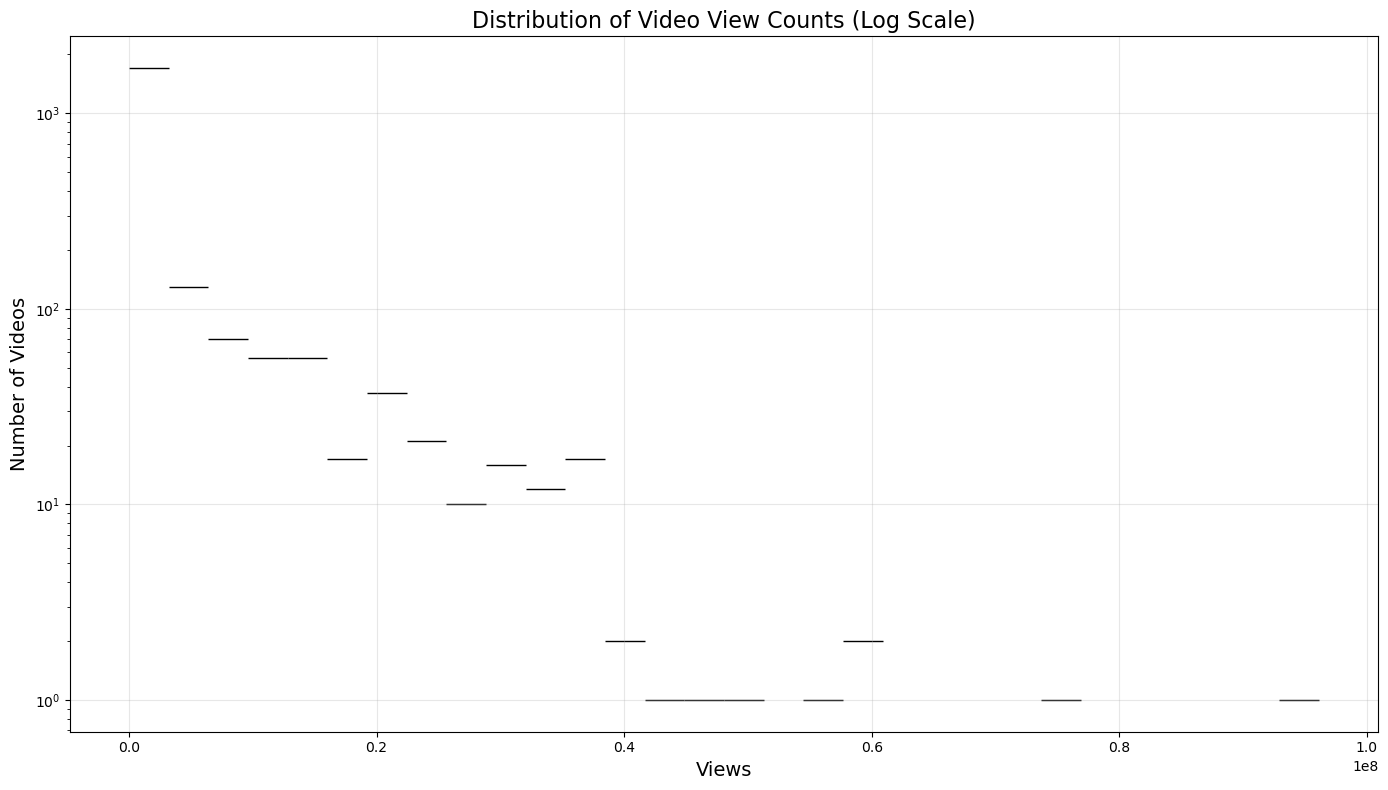

In [ ]:
# Histogram of view counts (log scale)
plt.figure(figsize=(14, 8))
sns.histplot(df['Views'], bins=30, log_scale=(False, True), kde=False)
plt.title('Distribution of Video View Counts (Log Scale)', fontsize=16)
plt.xlabel('Views', fontsize=14)
plt.ylabel('Number of Videos', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Cross Category Analysis

/var/folders/6_/4pssx0rj0ln4w7ysqm50xw400000gn/T/ipykernel_99475/2639030197.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=category_avg_views.index, y=category_avg_views.values, palette='viridis')


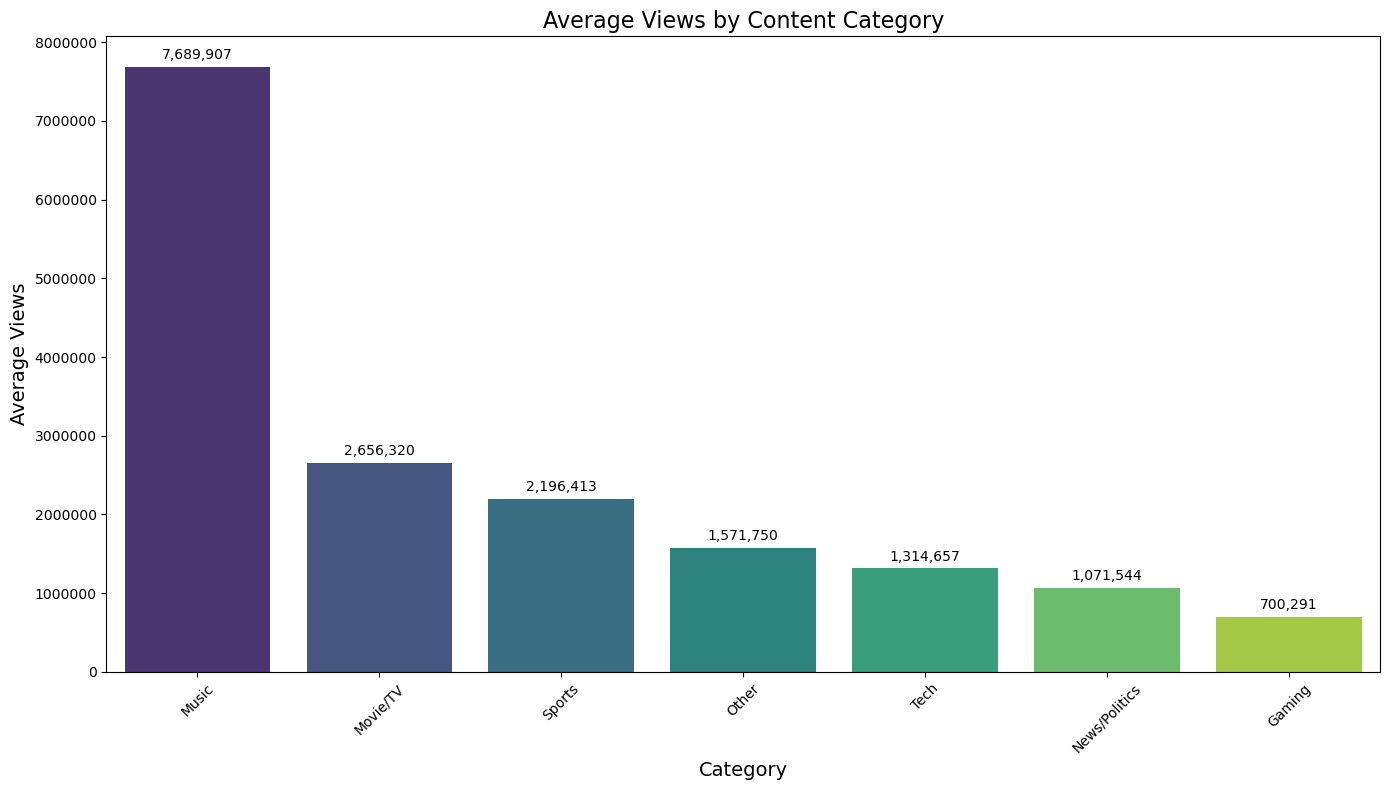

In [ ]:
# Average views by content category
category_avg_views = df.groupby('Category')['Views'].mean().sort_values(ascending=False)
plt.figure(figsize=(14, 8))
ax = sns.barplot(x=category_avg_views.index, y=category_avg_views.values, palette='viridis')
plt.title('Average Views by Content Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Average Views', fontsize=14)
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')

# Add formatted view count labels
for i, v in enumerate(category_avg_views.values):
    ax.text(i, v + 100000, f"{v:,.0f}", ha='center')

plt.tight_layout()
plt.show()

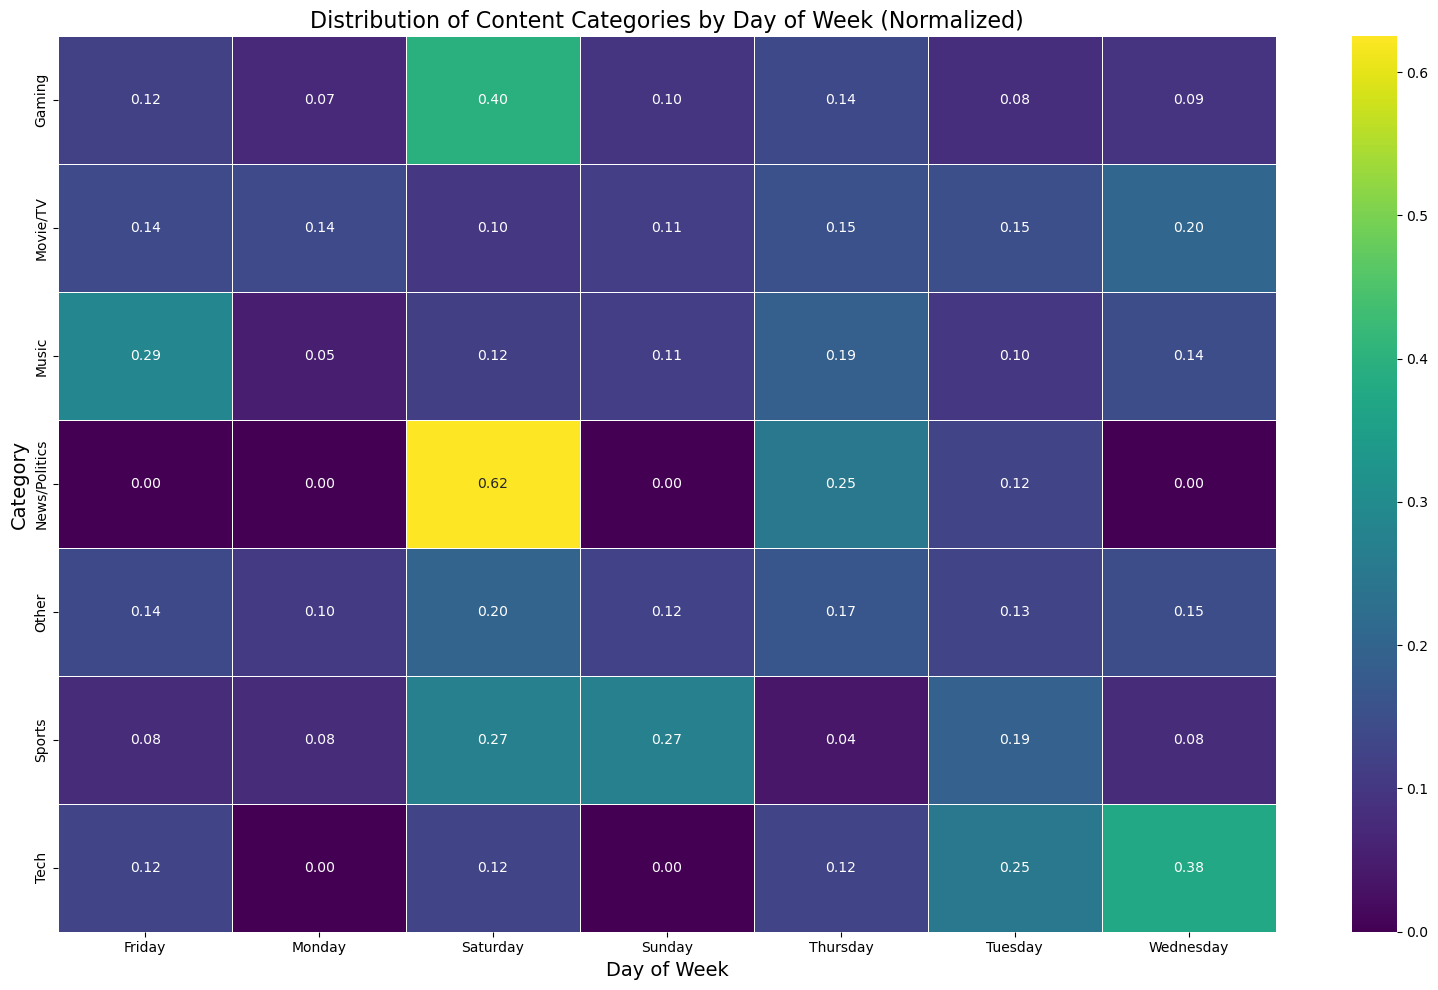

In [ ]:
# Distribution of categories by day of week
category_day_counts = pd.crosstab(df['Category'], df['Day of Week'])
category_day_pct = category_day_counts.div(category_day_counts.sum(axis=1), axis=0)

plt.figure(figsize=(16, 10))
sns.heatmap(category_day_pct, annot=True, cmap='viridis', fmt='.2f', linewidths=.5)
plt.title('Distribution of Content Categories by Day of Week (Normalized)', fontsize=16)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Category', fontsize=14)
plt.tight_layout()
plt.show()

/var/folders/6_/4pssx0rj0ln4w7ysqm50xw400000gn/T/ipykernel_99475/1134500911.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=category_avg_duration.index, y=category_avg_duration.values, palette='viridis')


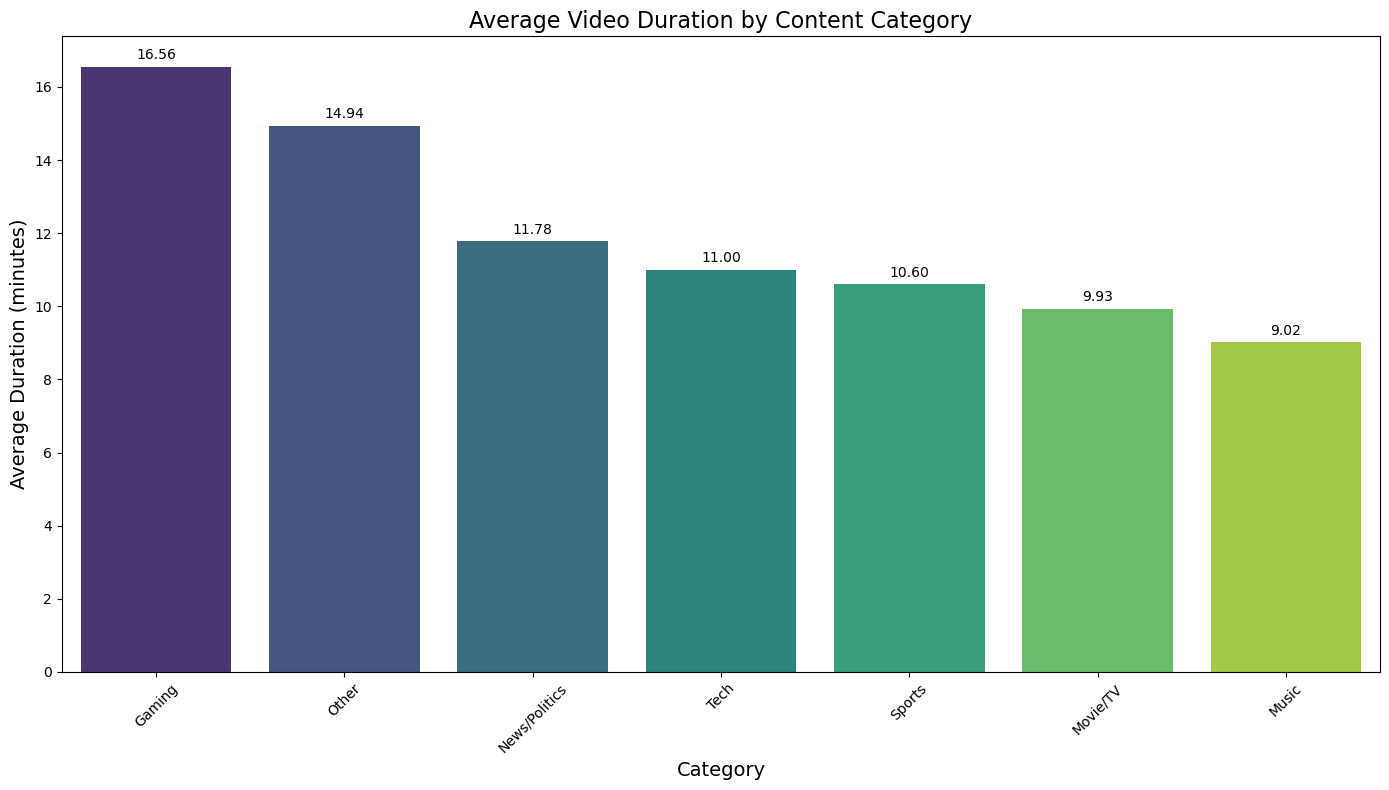

In [ ]:
# Average duration by category
category_avg_duration = df.groupby('Category')['Duration (min)'].mean().sort_values(ascending=False)
plt.figure(figsize=(14, 8))
ax = sns.barplot(x=category_avg_duration.index, y=category_avg_duration.values, palette='viridis')
plt.title('Average Video Duration by Content Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Average Duration (minutes)', fontsize=14)
plt.xticks(rotation=45)

# Add formatted duration labels
for i, v in enumerate(category_avg_duration.values):
    ax.text(i, v + 0.2, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.show()

## Key Content Creators Analysis

/var/folders/6_/4pssx0rj0ln4w7ysqm50xw400000gn/T/ipykernel_99475/3105123908.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=channel_avg_views.index, y=channel_avg_views.values, palette='viridis')


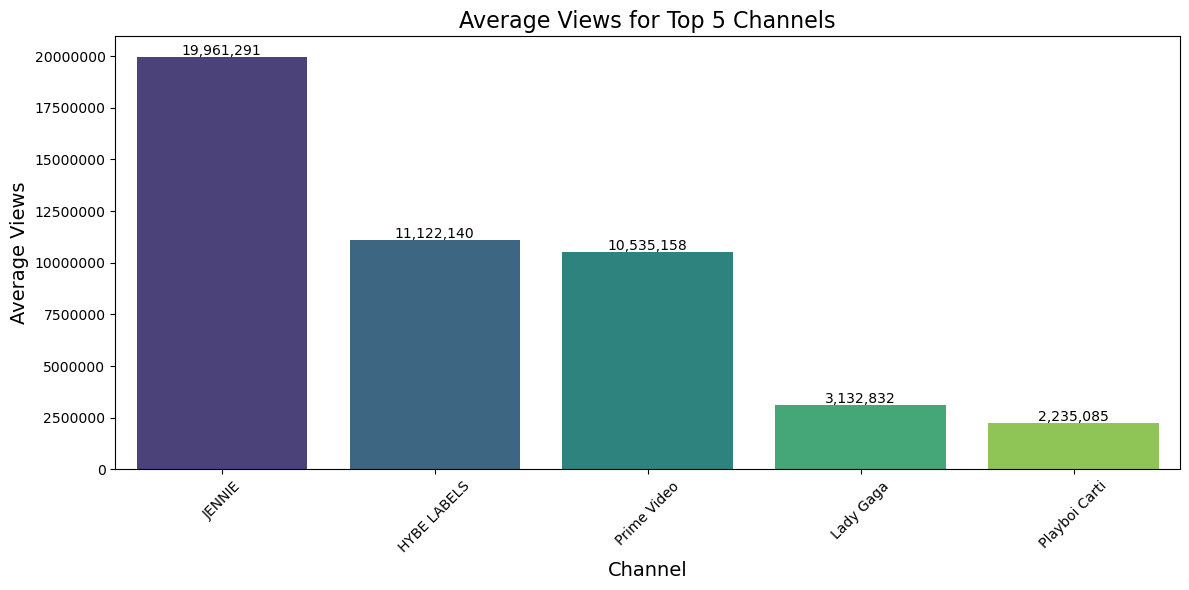

In [ ]:
# Top 5 channels statistics
top_5_channels = df['Channel Name'].value_counts().head(5).index.tolist()
top_channels_df = df[df['Channel Name'].isin(top_5_channels)]

# Average views comparison
channel_avg_views = top_channels_df.groupby('Channel Name')['Views'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=channel_avg_views.index, y=channel_avg_views.values, palette='viridis')
plt.title('Average Views for Top 5 Channels', fontsize=16)
plt.xlabel('Channel', fontsize=14)
plt.ylabel('Average Views', fontsize=14)
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')

# Add formatted view count labels
for i, v in enumerate(channel_avg_views.values):
    ax.text(i, v + 100000, f"{v:,.0f}", ha='center')

plt.tight_layout()
plt.show()

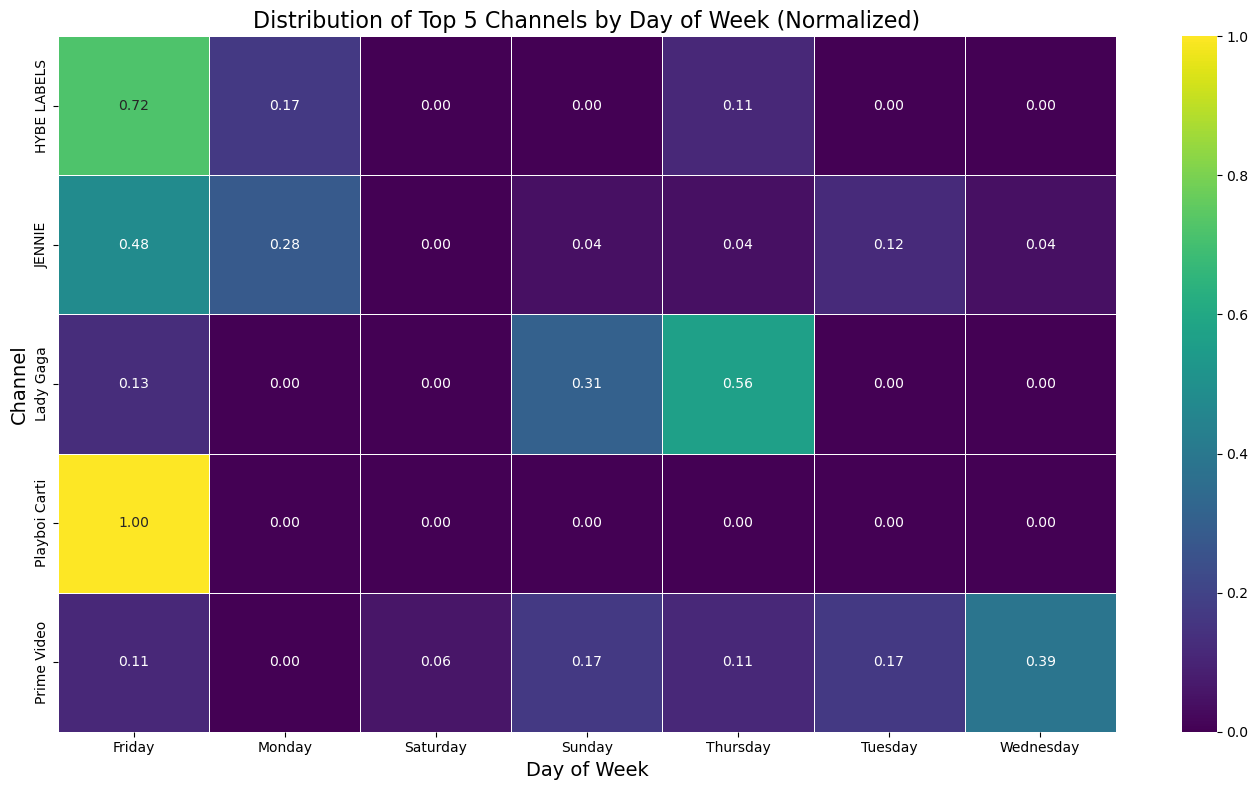

In [ ]:
# Distribution of top channels by day of week
top_channel_days = pd.crosstab(top_channels_df['Channel Name'], top_channels_df['Day of Week'])
top_channel_days_pct = top_channel_days.div(top_channel_days.sum(axis=1), axis=0)

plt.figure(figsize=(14, 8))
sns.heatmap(top_channel_days_pct, annot=True, cmap='viridis', fmt='.2f', linewidths=.5)
plt.title('Distribution of Top 5 Channels by Day of Week (Normalized)', fontsize=16)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Channel', fontsize=14)
plt.tight_layout()
plt.show()

## Strategic Insights

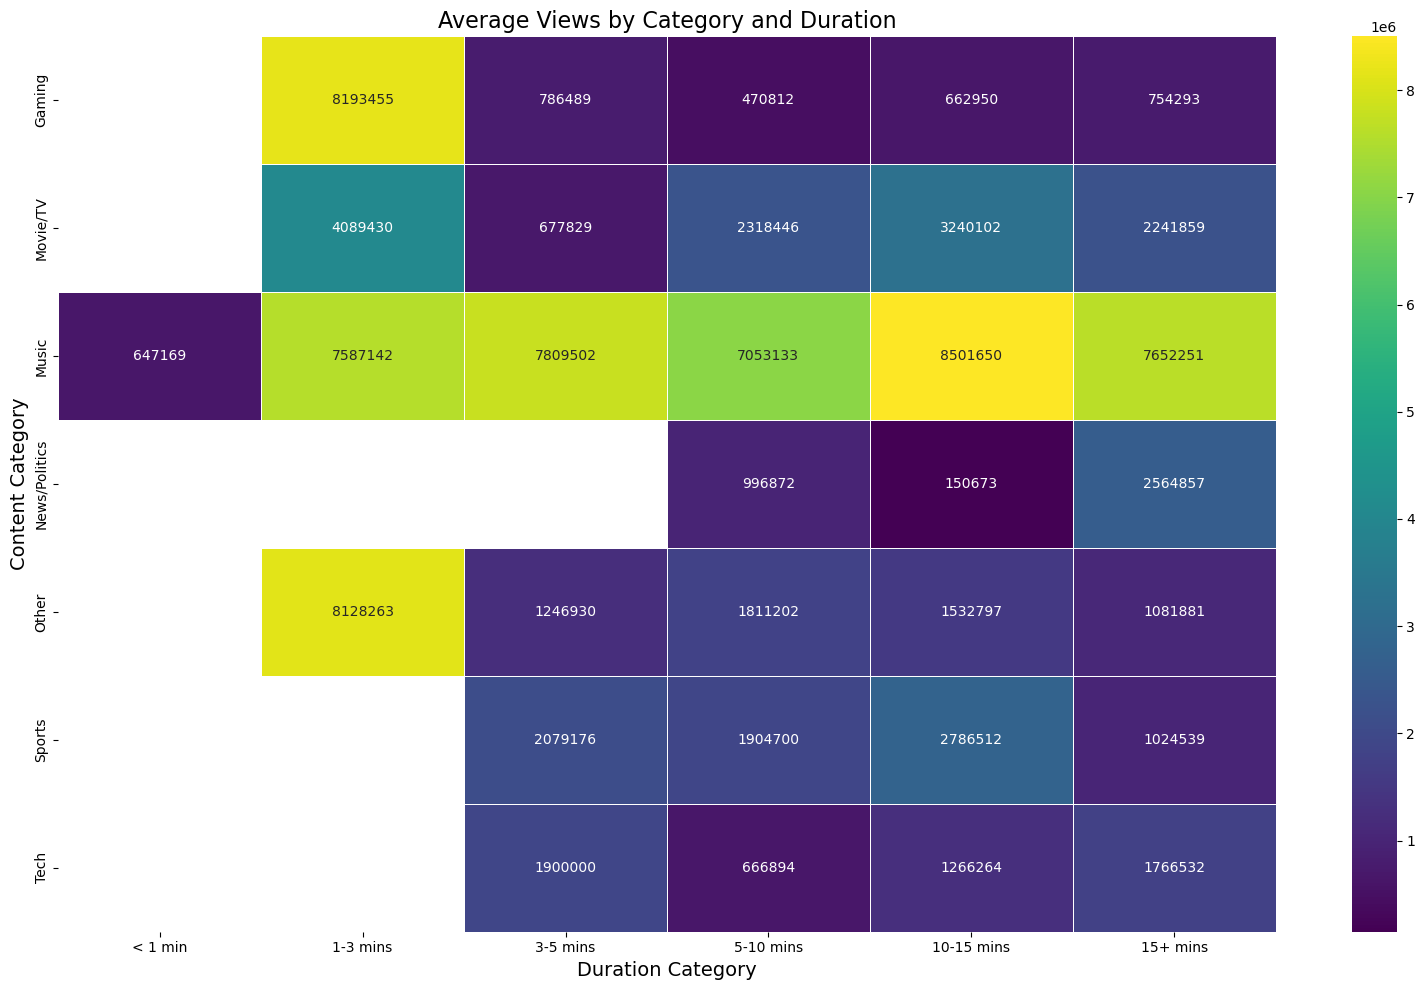

Optimal Video Duration by Content Category:
              Optimal Duration  Max Average Views
Category                                         
Gaming                1-3 mins       8.193455e+06
Movie/TV              1-3 mins       4.089430e+06
Music               10-15 mins       8.501650e+06
News/Politics         15+ mins       2.564857e+06
Other                 1-3 mins       8.128263e+06
Sports              10-15 mins       2.786512e+06
Tech                  3-5 mins       1.900000e+06


In [ ]:
# Optimal duration by category (based on average views)
duration_category_views = df.groupby(['Category', 'Duration Category'])['Views'].mean().reset_index()
pivot_data = pd.pivot_table(
    duration_category_views, 
    values='Views', 
    index='Category',
    columns='Duration Category'
).reindex(columns=duration_order)

plt.figure(figsize=(16, 10))
sns.heatmap(pivot_data, annot=True, cmap='viridis', fmt='.0f', linewidths=.5)
plt.title('Average Views by Category and Duration', fontsize=16)
plt.xlabel('Duration Category', fontsize=14)
plt.ylabel('Content Category', fontsize=14)
plt.tight_layout()
plt.show()

# Find the optimal duration category for each content category
optimal_duration = pivot_data.idxmax(axis=1).to_frame('Optimal Duration')
optimal_duration['Max Average Views'] = pivot_data.max(axis=1)
print("Optimal Video Duration by Content Category:")
print(optimal_duration)

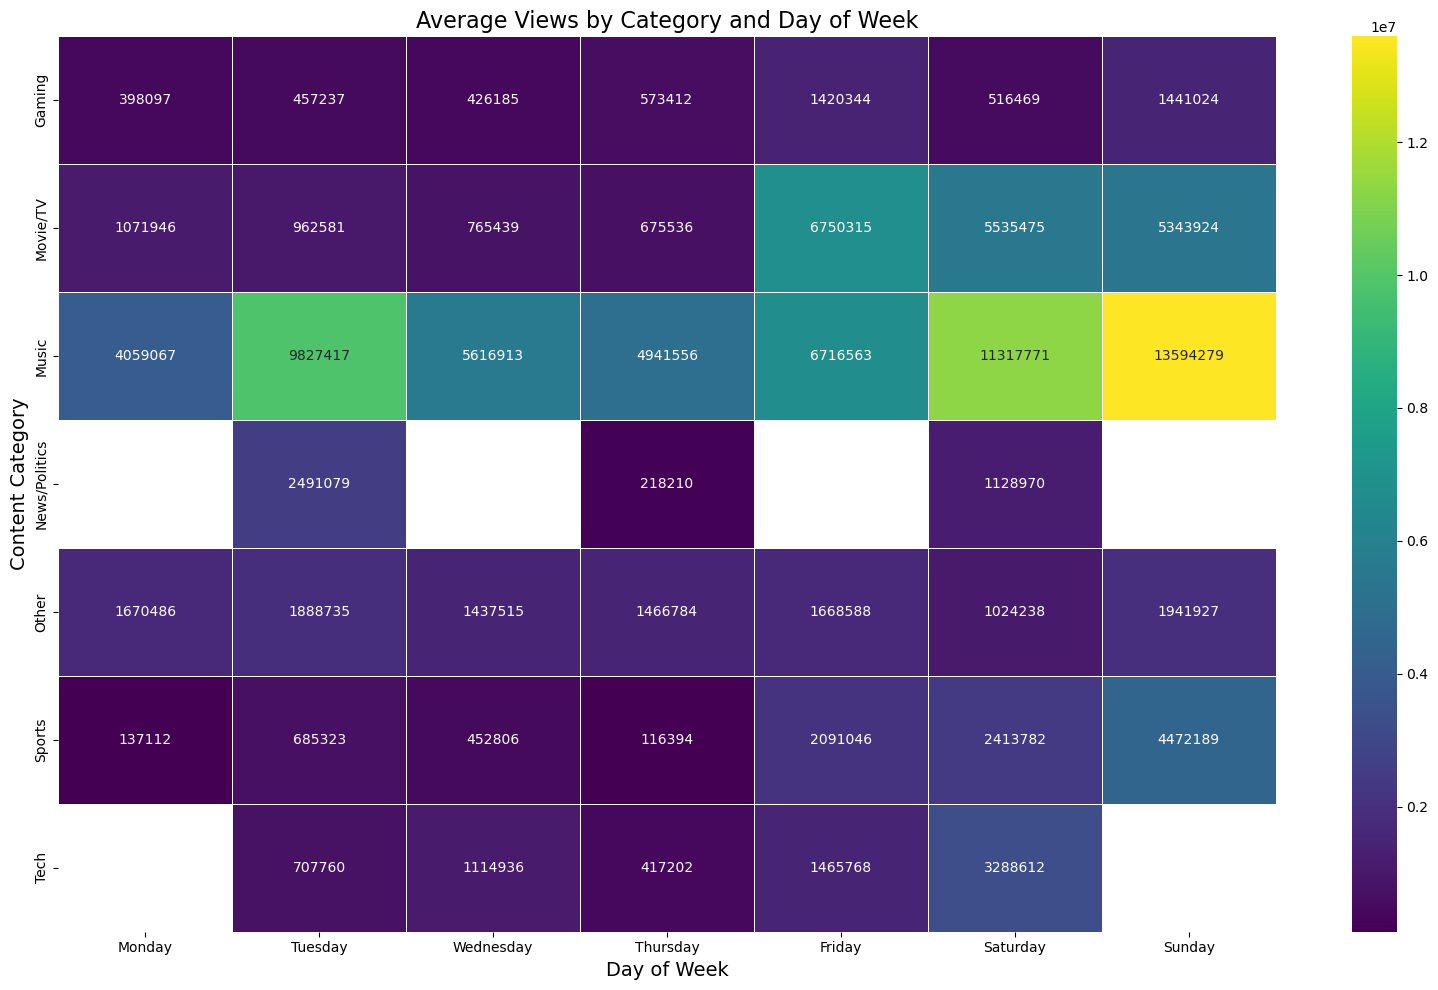

Optimal Publishing Day by Content Category:
              Optimal Publishing Day  Max Average Views
Category                                               
Gaming                        Sunday       1.441024e+06
Movie/TV                      Friday       6.750315e+06
Music                         Sunday       1.359428e+07
News/Politics                Tuesday       2.491079e+06
Other                         Sunday       1.941927e+06
Sports                        Sunday       4.472189e+06
Tech                        Saturday       3.288612e+06


In [ ]:
# Best publishing day by category (based on average views)
day_category_views = df.groupby(['Category', 'Day of Week'])['Views'].mean().reset_index()
day_pivot = pd.pivot_table(
    day_category_views, 
    values='Views', 
    index='Category',
    columns='Day of Week'
).reindex(columns=day_order)

plt.figure(figsize=(16, 10))
sns.heatmap(day_pivot, annot=True, cmap='viridis', fmt='.0f', linewidths=.5)
plt.title('Average Views by Category and Day of Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Content Category', fontsize=14)
plt.tight_layout()
plt.show()

# Find the optimal publishing day for each content category
optimal_day = day_pivot.idxmax(axis=1).to_frame('Optimal Publishing Day')
optimal_day['Max Average Views'] = day_pivot.max(axis=1)
print("Optimal Publishing Day by Content Category:")
print(optimal_day)

## Summary of Key Findings

**1. Top Content Creators**
- Lady Gaga leads with the most trending videos (35)
- Trending Shorts (30) and JENNIE (23) follow closely
- Prime Video and HYBE LABELS have 16 trending videos each

**2. Content Trends**
- Music content dominates the trending section
- Popular keywords: "official" (501), "video" (353), and "trailer" (291)
- Gaming content (especially Minecraft, Fortnite, and Roblox) remains popular
- Movie and TV trailers form a significant portion of trending content

**3. Publishing Patterns**
- Thursday is the most effective day for videos to trend (404 videos)
- Wednesday follows with 337 trending videos
- Weekend posts (especially Saturday with only 109 videos) are less represented

**4. Duration Insights**
- Average video duration is 3:36 minutes (216 seconds)
- Short-form content (1-3 minutes) tends to receive the highest average view counts
- Slight negative correlation (-0.19) between video duration and view count

**5. View Count Distribution**
- Average trending video receives 3.57 million views
- Median view count is 698,119 (indicating many viral outliers)
- Most trending videos fall into the 500K-5M views range

**6. Strategic Recommendations**
- Optimize content length: Shorter videos between 1-5 minutes perform best overall
- Timing matters: Mid-week publishing gives content the best chance of trending
- Content categories: Music, gaming, and movie/TV content consistently trend
- Each content category has an optimal duration and publishing day for maximum views